# Import Required Libraries

In [301]:
import os
import pandas as pd
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import math
from collections import OrderedDict
import base64
from PIL import Image
import easyocr
import torch
import torchvision.ops as ops

# Define Constants

In [302]:
DATA_ROOT = '/Users/deepthisivaram/Documents/DL/Final Project/Dataset_RF'
IMG_SIZE = 640
BATCH_SIZE = 8
NUM_WORKERS = 0
EMBEDDING_DIM = 128
HIDDEN_DIM = 256

In [303]:
if not os.path.exists(DATA_ROOT):
    print(f"Warning: Dataset path {DATA_ROOT} not found. Please update DATA_ROOT.")

# Define Classes

In [304]:
ALL_CLASSES = [
    'Select', 'Button', 'Image', 'Textbox', 'Paragraph',
    'Check Box', 'Radio Button', 'Link', 'Table',
    'Heading', 'Label', 'Carousel', 'Textarea', 'Pagination'
]

# Data Preprocessing

In [305]:
class UISketchDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.split_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.class_to_idx = {cls: idx for idx, cls in enumerate(ALL_CLASSES)}
        self.idx_to_class = {idx: cls for idx, cls in enumerate(ALL_CLASSES)}
        
        self.annotations = pd.read_csv(
            os.path.join(self.split_dir, '_annotations.csv'),
            dtype={'xmin': int, 'ymin': int, 'xmax': int, 'ymax': int}
        )

        # Strip spaces
        self.annotations['class'] = self.annotations['class'].str.strip()

        # Store image dimensions from CSV
        self.image_sizes = {
            row['filename']: (row['width'], row['height'])
            for _, row in self.annotations.iterrows()
        }

        self._clean_data()
        
        print(f"\n{split.capitalize()} Dataset Stats:")
        print(f"Images: {len(self.image_files)}")
        print(f"Annotations: {len(self.annotations)}")
        print("Class distribution:")
        print(self.annotations['class'].value_counts())

    def _clean_data(self):
        self.annotations = self.annotations[self.annotations['class'].isin(ALL_CLASSES)]
        self.image_files = []
        
        for img_name in self.annotations['filename'].unique():
            img_path = os.path.join(self.split_dir, img_name)
            if os.path.exists(img_path):
                self.image_files.append(img_name)
            else:
                print(f"Warning: Missing image - {img_name}")
        
        self.annotations = self.annotations[self.annotations['filename'].isin(self.image_files)]

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.split_dir, img_name)

        # Get image dimensions
        w, h = self.image_sizes[img_name]

        try:
            image = cv2.imread(img_path)
            if image is None:
                print(f"Error: Could not load image {img_path}")
                return (
                    torch.zeros((3, IMG_SIZE, IMG_SIZE)),
                    torch.zeros((0, 6))
                )
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Get annotations for the image
            img_anns = self.annotations[self.annotations['filename'] == img_name]
            boxes = img_anns[['xmin', 'ymin', 'xmax', 'ymax']].values
            labels = [self.class_to_idx[cls] for cls in img_anns['class']]

            # Convert to YOLO format
            yolo_boxes = np.array([[
                ((x1 + x2) / 2) / w,   
                ((y1 + y2) / 2) / h,   
                (x2 - x1) / w,         
                (y2 - y1) / h          
            ] for x1, y1, x2, y2 in boxes], dtype=np.float32)

            labels = np.array(labels, dtype=np.int64)

            # Apply transforms
            if self.transform:
                transformed = self.transform(
                    image=image,
                    bboxes=yolo_boxes,
                    class_labels=labels
                )
                image = transformed['image']
                boxes = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)
                labels = torch.as_tensor(transformed['class_labels'], dtype=torch.int64)
            else:
                image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
                boxes = torch.as_tensor(yolo_boxes, dtype=torch.float32)
                labels = torch.as_tensor(labels, dtype=torch.int64)

            # Format target for YOLO [image_id, class_id, cx, cy, w, h]
            target = torch.zeros((len(labels), 6))
            target[:, 0] = idx  
            target[:, 1] = labels 
            target[:, 2:6] = boxes

            return image, target

        except Exception as e:
            print(f"Error loading {img_name}: {str(e)}")
            return (
                torch.zeros((3, IMG_SIZE, IMG_SIZE)),
                torch.zeros((0, 6))
            )

### Data Augmentation using Albumentations

In [306]:
def get_yolo_transform(train=True):
    transforms = [
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
        ToTensorV2()
    ]

    if train:
        transforms = [
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.Blur(blur_limit=3, p=0.1),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.ToGray(p=0.1),
            A.Affine(scale=(0.9, 1.1), translate_percent=0.1, rotate=(-10, 10), p=0.2),
        ] + transforms

    return A.Compose(
        transforms,
        bbox_params=A.BboxParams(
            format='yolo',
            label_fields=['class_labels'],
            min_visibility=0.2
        )
    )

In [307]:
def collate_fn(batch):
    images = []
    targets = []

    for img, target in batch:
        images.append(img)
        targets.append(target)

    images = torch.stack(images, 0)

    for i, target in enumerate(targets):
        if target.shape[0] > 0:
            target[:, 0] = i

    targets = torch.cat(targets, 0)
    return images, targets

In [308]:
train_dataset = UISketchDataset(
        root_dir=DATA_ROOT,
        split='train/images/',
        transform=get_yolo_transform(train=True)
    )
val_dataset = UISketchDataset(
        root_dir=DATA_ROOT,
        split='valid/images/',
        transform=get_yolo_transform(train=False)
    )
train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        collate_fn=collate_fn,
        pin_memory=True
    )
val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        collate_fn=collate_fn,
        pin_memory=True
    )


Train/images/ Dataset Stats:
Images: 192
Annotations: 3883
Class distribution:
class
Textbox         515
Button          424
Image           408
Link            384
Select          272
Check Box       265
Label           261
Heading         258
Paragraph       231
Radio Button    231
Table           195
Carousel        169
Pagination      150
Textarea        120
Name: count, dtype: int64

Valid/images/ Dataset Stats:
Images: 24
Annotations: 541
Class distribution:
class
Check Box       157
Radio Button     73
Select           65
Link             64
Label            58
Textarea         31
Image            21
Heading          20
Table            19
Paragraph        16
Button            9
Textbox           8
Name: count, dtype: int64


# Sample Data Visualization with Annotations

In [309]:
def visualize_batch(images, targets):
    batch_size = images.shape[0]
    fig, axes = plt.subplots(1, batch_size, figsize=(20, 5))
    
    if batch_size == 1:
        axes = [axes]
    
    images = images.permute(0, 2, 3, 1).cpu().numpy()
    images = np.clip(images, 0, 1)
    
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        
        img_targets = targets[targets[:, 0] == i]
        
        for target in img_targets:
            _, class_id, cx, cy, w, h = target.tolist()
            
            # Convert YOLO to pixel coordinates
            x1 = int((cx - w/2) * IMG_SIZE)
            y1 = int((cy - h/2) * IMG_SIZE)
            x2 = int((cx + w/2) * IMG_SIZE)
            y2 = int((cy + h/2) * IMG_SIZE)
            
            rect = plt.Rectangle(
                (x1, y1), x2-x1, y2-y1,
                fill=False, color='red', linewidth=2
            )
            ax.add_patch(rect)
            
            ax.text(
                x1, y1-10, ALL_CLASSES[int(class_id)],
                color='red', fontsize=10, weight='bold'
            )
        
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

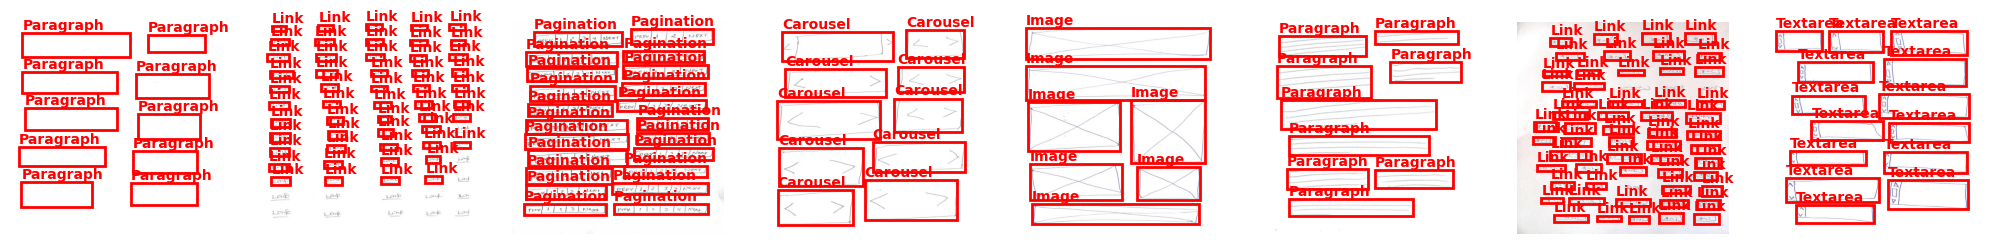

In [310]:
images, targets = next(iter(train_loader))
visualize_batch(images, targets)

### Custom CNN Feature Extractor

In [311]:
class CustomFeatureExtractor(nn.Module):
    def __init__(self, in_channels=3, embedding_dim=EMBEDDING_DIM):
        super(CustomFeatureExtractor, self).__init__()
    
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.btn_detector = nn.Conv2d(128, 64, kernel_size=5, padding=2)
        self.input_detector = nn.Conv2d(128, 64, kernel_size=5, padding=2)
        self.checkbox_detector = nn.Conv2d(128, 64, kernel_size=3, padding=1)

        self.final_conv = nn.Conv2d(64*3, embedding_dim, kernel_size=1)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        
        btn_features = F.relu(self.btn_detector(x))
        input_features = F.relu(self.input_detector(x))
        checkbox_features = F.relu(self.checkbox_detector(x))
        
        combined = torch.cat([btn_features, input_features, checkbox_features], dim=1)
        features = self.final_conv(combined)
        
        global_features = self.avg_pool(features).squeeze(-1).squeeze(-1)
        
        return features, global_features

### Self-Attention Module

In [312]:
class UIElementAttention(nn.Module):
    def __init__(self, embedding_dim=EMBEDDING_DIM):
        super(UIElementAttention, self).__init__()
        
        self.query = nn.Linear(embedding_dim, embedding_dim)
        self.key = nn.Linear(embedding_dim, embedding_dim)
        self.value = nn.Linear(embedding_dim, embedding_dim)
        
        self.scaling_factor = math.sqrt(embedding_dim)
        
    def forward(self, x, mask=None):
        x = F.layer_norm(x, x.shape[-1:])
        x = F.dropout(x, p=0.1, training=self.training)
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)
        
        temperature = 0.01
        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.scaling_factor * temperature)
        scores = scores - scores.max(dim=-1, keepdim=True)[0]

        if mask is not None:
            print("Mask sum per sample:", mask.sum(dim=1))
            expanded_mask = mask.unsqueeze(1).expand_as(scores)
            scores = scores.masked_fill(expanded_mask == 0, -1e4)

        attention_weights = F.softmax(scores, dim=-1)
        
        output = torch.matmul(attention_weights, v)

        print("Attention Weights Stats:")
        print("Min:", attention_weights.min().item(), "Max:", attention_weights.max().item())

        return output, attention_weights

### Transformer-Based UI Hierarchy Model

In [313]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=256):
        super(PositionalEncoding, self).__init__()
        
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
        self.rel_pos_encoder = nn.Linear(4, d_model)
        
    def forward(self, x, box_coords=None):
        x = x + self.pe[:, :x.size(1)]
        if box_coords is not None:
            normalized_coords = box_coords / IMG_SIZE
            rel_pos_emb = self.rel_pos_encoder(normalized_coords)
            x = x + rel_pos_emb
            
        return self.dropout(x)

In [314]:
class UITransformerBlock(nn.Module):
    def __init__(self, embedding_dim=EMBEDDING_DIM, num_heads=4, ff_dim=HIDDEN_DIM, dropout=0.1):
        super(UITransformerBlock, self).__init__()
        
        self.self_attn = nn.MultiheadAttention(embedding_dim, num_heads, dropout=dropout)
        
        self.ff = nn.Sequential(
            nn.Linear(embedding_dim, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, embedding_dim)
        )
        
        self.norm1 = nn.LayerNorm(embedding_dim)
        self.norm2 = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        x_norm = self.norm1(x)
        attn_output, _ = self.self_attn(x_norm.transpose(0, 1),
                                x_norm.transpose(0, 1),
                                x_norm.transpose(0, 1),
                                key_padding_mask=mask)
        attn_output = attn_output.transpose(0, 1)
        x = x + self.dropout(attn_output)
        
        x_norm = self.norm2(x)
        ff_output = self.ff(x_norm)
        x = x + self.dropout(ff_output)
        
        return x

In [315]:
class UIHierarchyTransformer(nn.Module):
    def __init__(self, embedding_dim=EMBEDDING_DIM, num_blocks=2, num_heads=4, ff_dim=HIDDEN_DIM, dropout=0.1):
        super(UIHierarchyTransformer, self).__init__()
        
        self.pos_encoder = PositionalEncoding(embedding_dim, dropout)
        
        self.blocks = nn.ModuleList([
            UITransformerBlock(embedding_dim, num_heads, ff_dim, dropout)
            for _ in range(num_blocks)
        ])
        
        self.relationship_classifier = nn.Linear(embedding_dim, len(ALL_CLASSES))
        
        self.spatial_classifier = nn.Linear(embedding_dim, 4)
        
    def forward(self, x, mask=None):
        x = self.pos_encoder(x)
        
        for block in self.blocks:
            x = block(x, mask)
        
        element_types = self.relationship_classifier(x)
        spatial_relations = self.spatial_classifier(x)
        
        return element_types, spatial_relations, x

### GRU-BASED HTML GENERATOR

In [316]:
class UIToHTMLGenerator(nn.Module):
    def __init__(self, input_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, 
                 output_vocab_size=len(ALL_CLASSES), num_layers=2, dropout=0.1):
        super(UIToHTMLGenerator, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.element_embedding = nn.Linear(input_dim, hidden_dim)
        
        self.gru = nn.GRU(
            hidden_dim, 
            hidden_dim, 
            num_layers=num_layers, 
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        self.tag_classifier = nn.Linear(hidden_dim, output_vocab_size)
        
        self.attr_generator = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
    def forward(self, element_features, element_positions, hidden=None):
        batch_size = element_features.size(0)
        
        if hidden is None:
            device = element_features.device
            hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        
        x = self.element_embedding(element_features)
        
        output, hidden = self.gru(x, hidden)
        
        html_tags = self.tag_classifier(output)
        html_attrs = self.attr_generator(output)
        
        return html_tags, html_attrs, hidden

### Multi Task Model

In [317]:
class UIFeatureEnhancementModel(nn.Module):
    def __init__(self, pretrained_yolo_path=None):
        super(UIFeatureEnhancementModel, self).__init__()
        
        self.yolo_model = YOLO(pretrained_yolo_path or 'yolov8s.pt')
        self.yolo_model.fuse()
        self.yolo_model.model.eval()
        
        self.feature_extractor = CustomFeatureExtractor()
        self.attention = UIElementAttention()
        self.hierarchy_transformer = UIHierarchyTransformer()
        self.html_generator = UIToHTMLGenerator()
        self.feature_fusion = nn.Linear(EMBEDDING_DIM * 2, EMBEDDING_DIM)

    def train(self, mode=True):
        for module in self.children():
            if module != self.yolo_model:
                module.train(mode)
        self.yolo_model.eval()
        return self

    def eval(self):
        for module in self.children():
            if module != self.yolo_model:
                module.eval()
        self.yolo_model.eval()
        return self

        
    def detect_elements(self, image):
        yolo_results = self.yolo_model(image)
        custom_features, global_features = self.feature_extractor(image)
        
        boxes = []
        labels = []
        confidences = []
        
        for result in yolo_results:
            batch_boxes = []
            batch_labels = []
            batch_confs = []
            
            for box in result.boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                cls_id = int(box.cls[0])
                conf = float(box.conf[0])
                
                batch_boxes.append([x1, y1, x2, y2])
                batch_labels.append(cls_id)
                batch_confs.append(conf)
            
            boxes.append(batch_boxes)
            labels.append(batch_labels)
            confidences.append(batch_confs)
        
        return boxes, labels, confidences, custom_features, global_features
    
    def process_layout(self, boxes, labels, custom_features):
        batch_size = custom_features.size(0)
        num_elements = max(len(batch_boxes) for batch_boxes in boxes) if boxes else 0
        
        if num_elements == 0:
            device = custom_features.device
            dummy_embeddings = torch.zeros(batch_size, 1, EMBEDDING_DIM).to(device)
            dummy_types = torch.zeros(batch_size, 1, len(ALL_CLASSES)).to(device)
            dummy_spatial = torch.zeros(batch_size, 1, 4).to(device)
            dummy_attn = torch.zeros(batch_size, 1, 1).to(device)
            return dummy_types, dummy_spatial, dummy_embeddings, dummy_attn
        
        device = custom_features.device
        element_embeddings = torch.zeros(batch_size, num_elements, EMBEDDING_DIM).to(device)
        
        mask = torch.zeros(batch_size, num_elements, dtype=torch.bool).to(device)
        
        for b in range(batch_size):
            for i, (box, _) in enumerate(zip(boxes[b], labels[b])):
                if i >= num_elements:
                    break
                    
                mask[b, i] = 1 
                
                x1, y1, x2, y2 = box
                
                h_scale = custom_features.size(2) / IMG_SIZE
                w_scale = custom_features.size(3) / IMG_SIZE
                
                roi_h_start = max(0, int(y1 * h_scale))
                roi_h_end = min(custom_features.size(2), int(y2 * h_scale))
                roi_w_start = max(0, int(x1 * w_scale))
                roi_w_end = min(custom_features.size(3), int(x2 * w_scale))
                
                if roi_h_end > roi_h_start and roi_w_end > roi_w_start:
                    roi_features = custom_features[b, :, roi_h_start:roi_h_end, roi_w_start:roi_w_end]
                    roi_features = F.adaptive_avg_pool2d(roi_features, (1, 1)).squeeze(-1).squeeze(-1)
                    
                    element_embeddings[b, i] = roi_features
        
        attended_elements, attention_weights = self.attention(element_embeddings, ~mask)
        attended_elements = attended_elements + element_embeddings
        
        element_types, spatial_relations, hierarchy_features = self.hierarchy_transformer(
            attended_elements, 
            mask=~mask
        )
        
        return element_types, spatial_relations, hierarchy_features, attention_weights
    
    def generate_html(self, hierarchy_features, boxes):
        batch_size = hierarchy_features.size(0)
        device = hierarchy_features.device
        
        max_elements = hierarchy_features.size(1)
        positions = torch.zeros(batch_size, max_elements, 4).to(device)
        
        for b in range(batch_size):
            for i, box in enumerate(boxes[b]):
                if i >= max_elements:
                    break
                positions[b, i] = torch.tensor(box, dtype=torch.float32, device=device)
        
        positions = positions / IMG_SIZE
        
        html_tags, html_attrs, _ = self.html_generator(hierarchy_features, positions)
        
        return html_tags, html_attrs
    
    def forward(self, image):
        boxes, labels, confidences, custom_features,_ = self.detect_elements(image)
        _, _, hierarchy_features, attention_weights = self.process_layout(
            boxes, labels, custom_features
        )
        
        html_tags, html_attrs = self.generate_html(hierarchy_features, boxes)
        
        return boxes, labels, confidences, html_tags, html_attrs, attention_weights

In [318]:
model = UIFeatureEnhancementModel(pretrained_yolo_path='/Users/deepthisivaram/Documents/DL/Final Project/best.pt')

Model summary (fused): 72 layers, 11,131,002 parameters, 0 gradients, 28.5 GFLOPs


# Model Training

In [319]:
def train_model(model, train_loader, val_loader, epochs=5, lr=1e-4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    tag_criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(
        [p for p in model.parameters() if p.requires_grad],
        lr=lr
    )

    attention_params = list(model.attention.parameters())
    for p in attention_params:
        p.requires_grad = True

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for images, targets in train_loader:
            images = images.to(device)
            boxes, labels, _, html_tags, _, _ = model(images)

            if not any(len(b) > 0 for b in boxes):
                continue

            batch_size = html_tags.size(0)
            preds = []
            gt_labels = []

            for i in range(batch_size):
                num_elements = html_tags[i].size(0)
                img_targets = targets[targets[:, 0] == i]

                if len(img_targets) == 0 or num_elements == 0:
                    continue

                num_pairs = min(len(img_targets), num_elements)
                preds.append(html_tags[i, :num_pairs])
                gt_labels.append(img_targets[:num_pairs, 1].long())

            if preds and gt_labels:
                preds = torch.cat(preds, dim=0)
                gt_labels = torch.cat(gt_labels, dim=0)
                loss = tag_criterion(preds, gt_labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}')

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, targets in val_loader:
                images = images.to(device)
                boxes, labels, _, html_tags, _, _ = model(images)

                if not any(len(b) > 0 for b in boxes):
                    continue

                batch_size = html_tags.size(0)
                preds = []
                gt_labels = []

                for i in range(batch_size):
                    num_elements = html_tags[i].size(0)
                    img_targets = targets[targets[:, 0] == i]

                    if len(img_targets) == 0 or num_elements == 0:
                        continue

                    num_pairs = min(len(img_targets), num_elements)
                    preds.append(html_tags[i, :num_pairs])
                    gt_labels.append(img_targets[:num_pairs, 1].long())

                if preds and gt_labels:
                    preds = torch.cat(preds, dim=0)
                    gt_labels = torch.cat(gt_labels, dim=0)
                    loss = tag_criterion(preds, gt_labels)
                    val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f'Validation Loss: {avg_val_loss:.4f}')

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("training_loss_curve.png")
    plt.show()

    return model


0: 640x640 13 Images, 129.6ms
1: 640x640 13 Paragraphs, 129.6ms
2: 640x640 1 Button, 5 Images, 3 Radio Buttons, 129.6ms
3: 640x640 14 Images, 129.6ms
4: 640x640 6 Check Boxs, 1 Radio Button, 129.6ms
5: 640x640 12 Images, 129.6ms
6: 640x640 3 Images, 10 Tables, 129.6ms
7: 640x640 21 Buttons, 129.6ms
Speed: 0.0ms preprocess, 129.6ms inference, 8.2ms postprocess per image at shape (1, 3, 640, 640)
Mask sum per sample: tensor([ 8,  8, 12,  7, 14,  9,  8,  0])
Attention Weights Stats:
Min: 0.0 Max: 0.1428571492433548

0: 640x640 28 Textboxs, 133.2ms
1: 640x640 3 Buttons, 1 Textbox, 11 Check Boxs, 1 Radio Button, 133.2ms
2: 640x640 38 Textboxs, 133.2ms
3: 640x640 28 Selects, 2 Textboxs, 133.2ms
4: 640x640 7 Images, 133.2ms
5: 640x640 8 Carousels, 133.2ms
6: 640x640 12 Tables, 133.2ms
7: 640x640 10 Carousels, 133.2ms
Speed: 0.0ms preprocess, 133.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Mask sum per sample: tensor([10, 22,  0,  8, 31, 30, 26, 28])
Attention Weights

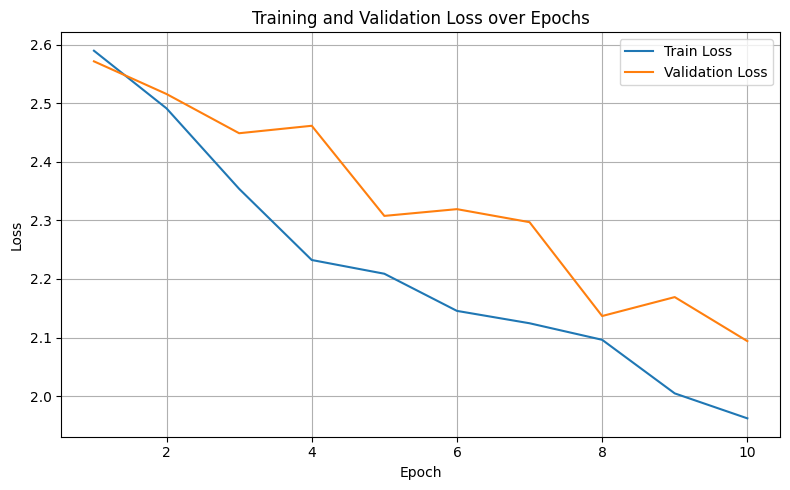

In [320]:
model = train_model(model, train_loader, val_loader, epochs=10)

# Saving Weights

In [321]:
torch.save(model.state_dict(), 'ui_detection_model.pt')

# Evaluation

In [270]:
test_images_dir = os.path.join(DATA_ROOT, 'test/images/')
valid_images = [f for f in os.listdir(test_images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
if not valid_images:
    raise ValueError("No valid test images found in the directory.")

In [172]:
test_image_path = os.path.join(test_images_dir, valid_images[2])

In [173]:
def is_near(x, y, box, padding=20):
    x1, y1, x2, y2 = box
    return (x1 - padding <= x <= x2 + padding) and (y1 - padding <= y <= y2 + padding)

In [174]:
def convert_to_html(image_path, boxes, labels, confidences, theme='default', enable_ocr=False):
    img = cv2.imread(image_path)
    img_height, img_width = img.shape[:2]

    ocr_results = []
    if enable_ocr:
        reader = easyocr.Reader(['en'])
        ocr_results = reader.readtext(img)
    
    _, buffer = cv2.imencode('.jpg', img)
    img_base64 = base64.b64encode(buffer).decode('utf-8')
    
    themes = {
        'default': {
            'background': '#f5f5f5', 'container_bg': 'white',
            'button_bg': '#4285f4', 'button_text': 'white',
            'text_color': '#333', 'paragraph_color': '#666',
            'border_color': '#ddd', 'shadow': '0 0 10px rgba(0,0,0,0.1)',
            'font': 'Arial, sans-serif'
        },
        'warm': {
            'background': '#fff8f0', 'container_bg': '#fffaf5',
            'button_bg': '#e67e22', 'button_text': 'white',
            'text_color': '#5d4037', 'paragraph_color': '#795548',
            'border_color': '#ffccbc', 'shadow': '0 0 10px rgba(230,126,34,0.2)',
            'font': 'Georgia, serif'
        },
        'cold': {
            'background': '#f0f8ff', 'container_bg': '#f5faff',
            'button_bg': '#3498db', 'button_text': 'white',
            'text_color': '#2c3e50', 'paragraph_color': '#34495e',
            'border_color': '#bde0fe', 'shadow': '0 0 10px rgba(52,152,219,0.2)',
            'font': 'Helvetica, Arial, sans-serif'
        },
        'minimal': {
            'background': '#ffffff', 'container_bg': '#ffffff',
            'button_bg': '#000000', 'button_text': 'white',
            'text_color': '#333333', 'paragraph_color': '#666666',
            'border_color': '#eeeeee', 'shadow': 'none',
            'font': 'Roboto, Arial, sans-serif'
        },
        'dark': {
            'background': '#121212', 'container_bg': '#1e1e1e',
            'button_bg': '#bb86fc', 'button_text': '#121212',
            'text_color': '#e0e0e0', 'paragraph_color': '#b0b0b0',
            'border_color': '#333333', 'shadow': '0 0 10px rgba(187,134,252,0.2)',
            'font': 'Inter, Arial, sans-serif'
        }
    }
    
    current_theme = themes.get(theme, themes['default'])
    
    element_templates = {
        'Button': '<button class="ui-button" style="position:absolute; left:{x}px; top:{y}px; width:{w}px; height:{h}px">{text}</button>',
        'Textbox': '<input type="text" class="ui-textbox" style="position:absolute; left:{x}px; top:{y}px; width:{w}px; height:{h}px" placeholder="{text}">',
        'Check Box': '<label class="ui-checkbox" style="position:absolute; left:{x}px; top:{y}px"><input type="checkbox"> {text}</label>',
        'Radio Button': '<label class="ui-radio" style="position:absolute; left:{x}px; top:{y}px"><input type="radio" name="radio-group"> {text}</label>',
        'Paragraph': '<p class="ui-paragraph" style="position:absolute; left:{x}px; top:{y}px; width:{w}px">{text}</p>',
        'Heading': '<h3 class="ui-heading" style="position:absolute; left:{x}px; top:{y}px">{text}</h3>',
        'Carousel': '<div class="ui-carousel" style="position:absolute; left:{x}px; top:{y}px; width:{w}px; height:{h}px; background:#f9f9f9; display:flex; align-items:center; justify-content:center">{text}</div>',
        'Select': '<select class="ui-select" style="position:absolute; left:{x}px; top:{y}px; width:{w}px"><option>{text}</option></select>',
        'Link': '<a href="#" class="ui-link" style="position:absolute; left:{x}px; top:{y}px">{text}</a>',
        'Label': '<label class="ui-label" style="position:absolute; left:{x}px; top:{y}px">{text}</label>',
        'Image': '<div class="ui-image" style="position:absolute; left:{x}px; top:{y}px; width:{w}px; height:{h}px; background:#eee; display:flex; align-items:center; justify-content:center">{text}</div>',
        'Textarea': '<textarea class="ui-textarea" style="position:absolute; left:{x}px; top:{y}px; width:{w}px; height:{h}px">{text}</textarea>',
        'Pagination': '<div class="ui-pagination" style="position:absolute; left:{x}px; top:{y}px; display:flex; gap:5px">{text}</div>',
        'Table': '<div class="ui-table" style="position:absolute; left:{x}px; top:{y}px; width:{w}px; height:{h}px; border:1px solid #ddd">{text}</div>',
        'default': '<div class="ui-element" style="position:absolute; left:{x}px; top:{y}px; width:{w}px; height:{h}px">{text}</div>'
    }
    
    html_elements = []

    elements = []
    for box, label_idx, conf in zip(boxes, labels, confidences):
        x1, y1, x2, y2 = box
        x1 = int(x1 * img_width / IMG_SIZE)
        y1 = int(y1 * img_height / IMG_SIZE)
        x2 = int(x2 * img_width / IMG_SIZE)
        y2 = int(y2 * img_height / IMG_SIZE)
        class_name = ALL_CLASSES[label_idx]
        elements.append({'box': (x1, y1, x2, y2), 'label': class_name, 'conf': conf, 'text': None})
    
    if enable_ocr:
        for detection in ocr_results:
            (bbox, text, _) = detection
            (top_left, _, bottom_right, _) = bbox
            text_x = int((top_left[0] + bottom_right[0]) / 2)
            text_y = int((top_left[1] + bottom_right[1]) / 2)
            for element in elements:
                if is_near(text_x, text_y, element['box']):
                    element['text'] = text.strip()

    for element in elements:
        x1, y1, x2, y2 = element['box']
        class_name = element['label']
        conf = element['conf']
        text = element['text'] if element['text'] else f"{class_name} ({conf:.2f})"
        template = element_templates.get(class_name, element_templates['default'])
        html_elements.append(template.format(x=x1, y=y1, w=x2-x1, h=y2-y1, text=text))
    
    if enable_ocr:
        for detection in ocr_results:
            (bbox, text, _) = detection
            (top_left, _, bottom_right, _) = bbox
            text_x = int((top_left[0] + bottom_right[0]) / 2)
            text_y = int((top_left[1] + bottom_right[1]) / 2)
            if not any(is_near(text_x, text_y, e['box']) for e in elements):
                html_elements.append(
                    f'<div style="position:absolute; left:{text_x}px; top:{text_y}px; font-size:14px; color:{current_theme["text_color"]};">{text}</div>'
                )
    
    html = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>UI Reconstruction</title>
        <style>
            body {{
                font-family: Arial, sans-serif;
                position: relative;
                margin: 0;
                padding: 0;
                min-height: 100vh;
                background: {current_theme['background']};
            }}
            .original-image {{
                position: absolute;
                opacity: 0.3;
                z-index: 0;
                max-width: 100%;
            }}
            .ui-container {{
                position: relative;
                z-index: 1;
                width: {img_width}px;
                height: {img_height}px;
                margin: 20px auto;
                background: {current_theme['container_bg']};
                box-shadow: 0 0 10px rgba(0,0,0,0.1);
            }}
            .ui-button {{
                background: {current_theme['button_bg']};
                color: {current_theme['button_text']};
                border: none;
                border-radius: 4px;
                padding: 8px 16px;
                cursor: pointer;
            }}
            .ui-textbox {{
                border: 1px solid {current_theme['border_color']};
                padding: 8px;
                border-radius: 4px;
            }}
            .ui-checkbox, .ui-radio {{
                display: flex;
                align-items: center;
                gap: 8px;
            }}
            .ui-heading {{
                color: {current_theme['text_color']};
                margin: 0;
            }}
            .ui-paragraph {{
                color: {current_theme['text_color']};
                margin: 0;
                line-height: 1.5;
            }}
            .ui-select {{
                padding: 8px;
                border-radius: 4px;
                border: 1px solid {current_theme['border_color']};
            }}
        </style>
    </head>
    <body>
        <div class="ui-container">
            <img class="original-image" src="data:image/jpg;base64,{img_base64}">
            {''.join(html_elements)}
        </div>
    </body>
    </html>
    """
    
    return html

In [175]:
def visualize_predictions(image_path, boxes, labels, confidences):

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    ax = plt.gca()

    for box, label, conf in zip(boxes, labels, confidences):
        x1, y1, x2, y2 = map(int, box)
        class_name = ALL_CLASSES[label]
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                             fill=False, edgecolor='green', linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, y1 - 5,
                f'{class_name} ({conf:.2f})',
                bbox=dict(facecolor='yellow', alpha=0.5),
                fontsize=10, color='black')

    plt.axis('off')
    plt.title('Model Predictions')
    plt.tight_layout()
    plt.show()


In [191]:
def generate_html_from_ui(model, image_path, theme, enable_ocr=False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image from {image_path}")
        
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
    image = image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        boxes, labels, confidences, _, _, attention_weights = model(image)
    
    visualize_predictions(image_path, boxes[0], labels[0], confidences[0])

    html_code = convert_to_html(image_path, boxes[0], labels[0], confidences[0], theme, enable_ocr)
    
    return html_code, attention_weights

## Visualizing the Model Predictions


0: 640x640 32 Buttons, 182.7ms
Speed: 0.0ms preprocess, 182.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)
Mask sum per sample: tensor([0])
Attention Weights Stats:
Min: 0.03125 Max: 0.03125


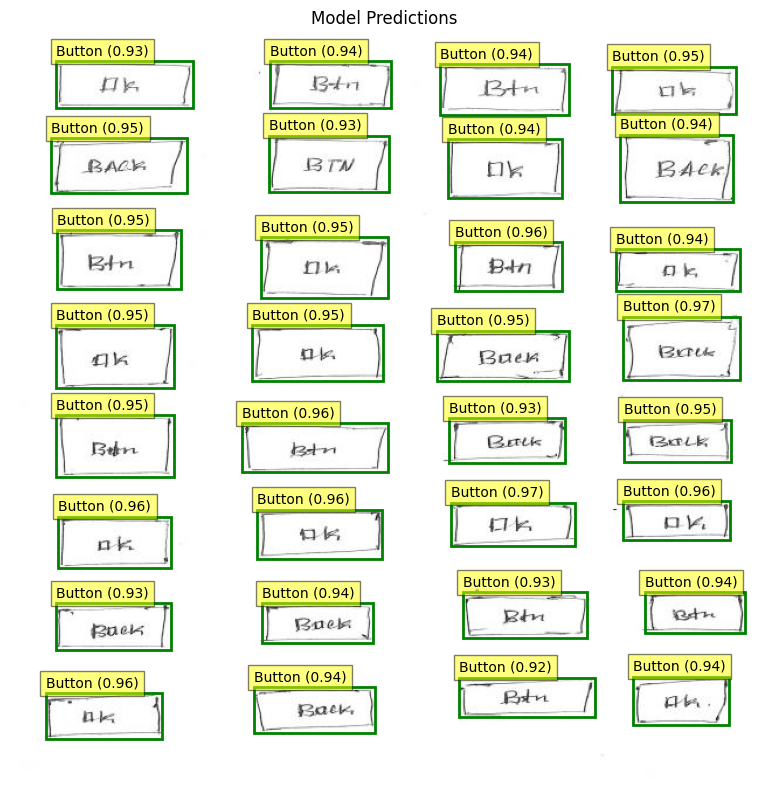

In [230]:
html_code, attention_weights = generate_html_from_ui(model, test_image_path, "dark")

### Saving the predictions as a HTML Page

In [231]:
with open("generated_ui.html", "w") as f:
    f.write(html_code)

### Visualizing the Element Attention Weights

In [179]:
def visualize_attention(image_path, attention_weights):
    import matplotlib.pyplot as plt
    import cv2
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    ax1.imshow(image)
    ax1.set_title("Original UI Image")
    ax1.axis('off')
    
    attn = attention_weights[0].cpu().numpy()
    im = ax2.imshow(attn, cmap='hot', interpolation='nearest', vmin=0, vmax=1)
    ax2.set_title("Element Attention Weights")
    ax2.set_xlabel("Element Index")
    ax2.set_ylabel("Element Index")
    
    plt.colorbar(im, ax=ax2)
    plt.tight_layout()
    plt.savefig("attention_visualization.png")
    plt.show()

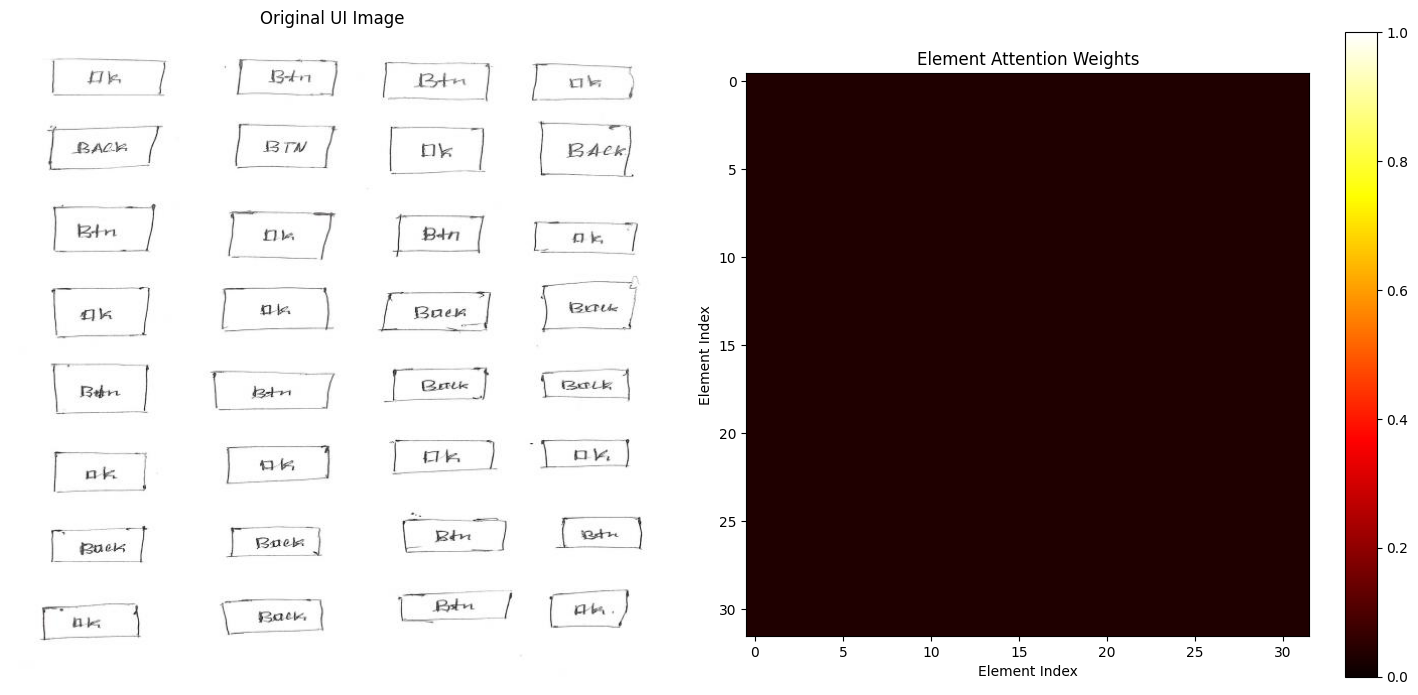

In [180]:
visualize_attention(test_image_path, attention_weights)

# Testing on a Random Hand Drawn Image

In [224]:
def preprocess_ui_image(image_path, target_size=(640, 640), contrast_enhance=False):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if contrast_enhance:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        gray = clahe.apply(gray)
    resized = cv2.resize(gray, target_size)
    processed_img = cv2.cvtColor(resized, cv2.COLOR_GRAY2BGR)

    return processed_img

In [225]:
pre_img = preprocess_ui_image("/Users/deepthisivaram/Downloads/IMG_3096.jpg", target_size=(640, 640), contrast_enhance=True)
cv2.imwrite("processed_ui_image.png", pre_img)

True

In [226]:
new_image_path = "processed_ui_image.png"


0: 640x640 1 Button, 2 Textboxs, 1 Check Box, 3 Labels, 179.6ms
Speed: 0.0ms preprocess, 179.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)
Mask sum per sample: tensor([0])
Attention Weights Stats:
Min: 0.1428571492433548 Max: 0.1428571492433548


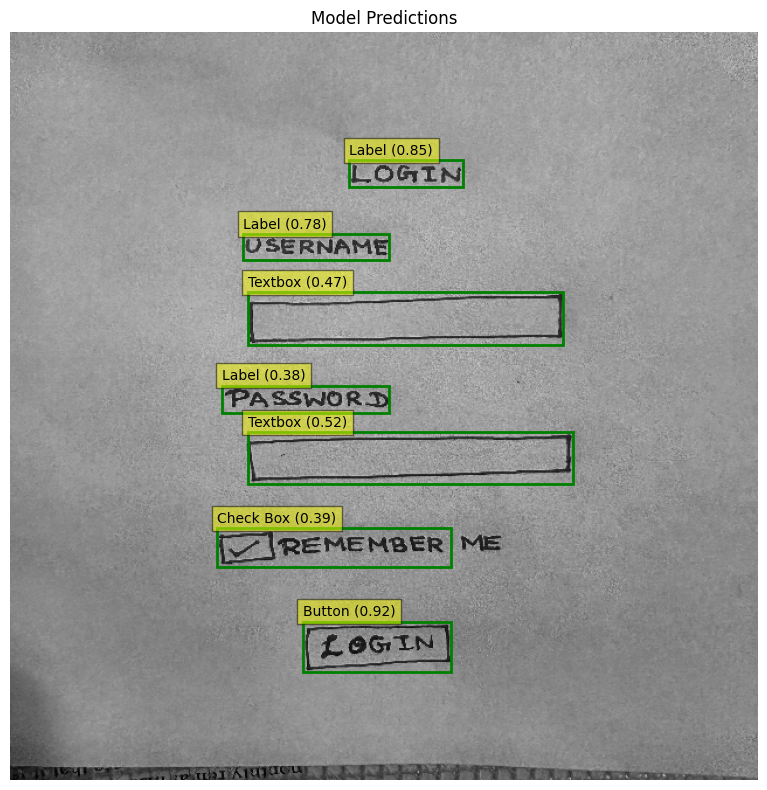

In [227]:
html_code, attention_weights = generate_html_from_ui(
    model=model, 
    image_path=new_image_path, 
    theme="warm",
    enable_ocr=True
)

In [228]:
with open("random_test_ui.html", "w") as f:
    f.write(html_code)

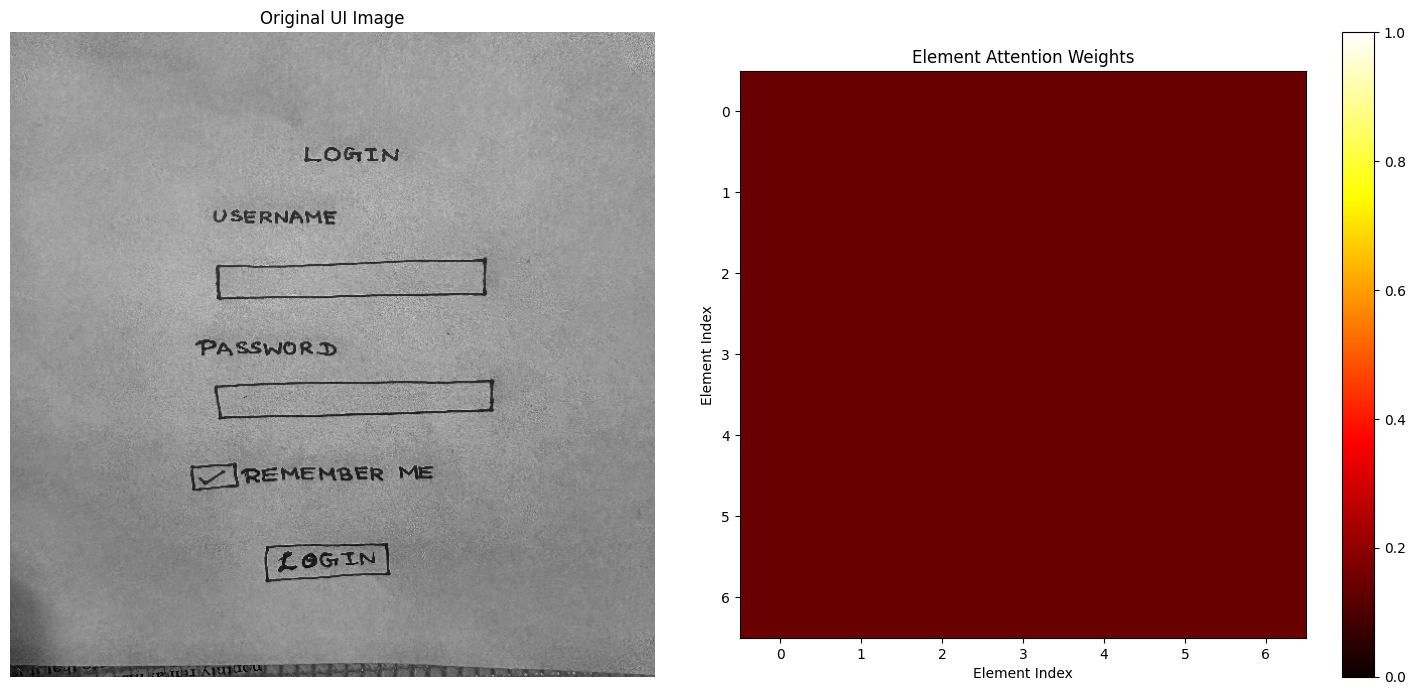

In [229]:
visualize_attention(new_image_path, attention_weights)